In [1]:
from google.colab import drive
from pathlib import Path
import os

drive.mount("/content/drive")

PROJECT = Path("/content/drive/MyDrive/gb-flex-desk")  # change name if you want
PROJECT.mkdir(parents=True, exist_ok=True)
os.chdir(PROJECT)

Path("data/raw").mkdir(parents=True, exist_ok=True)
Path("data/processed").mkdir(parents=True, exist_ok=True)

print("cwd:", Path.cwd())
print("prices exists?", Path("data/processed/prices.parquet").exists())

Mounted at /content/drive
cwd: /content/drive/MyDrive/gb-flex-desk
prices exists? True


In [5]:
import pandas as pd

prices = pd.read_parquet("data/processed/prices.parquet").sort_values("ts").reset_index(drop=True)
prices["price"] = prices["sbp"]  # SBP and SSP are the same here, so use one series

print("rows:", len(prices))
print("columns:", list(prices.columns))
print("time range:", prices["ts"].min(), "to", prices["ts"].max())

# Single imbalance price, so treat as one series
prices["price"] = prices["sbp"]
print("max |sbp-ssp|:", (prices["sbp"] - prices["ssp"]).abs().max())

prices.head()

rows: 17568
columns: ['ts', 'ssp', 'sbp', 'price']
time range: 2024-12-06 00:00:00 to 2025-12-06 23:30:00
max |sbp-ssp|: 0.0


,ts,ssp,sbp,price
0,2024-12-06 00:00:00,2.98,2.98,2.98
1,2024-12-06 00:30:00,7.24,7.24,7.24
2,2024-12-06 01:00:00,1.56,1.56,1.56
3,2024-12-06 01:30:00,56.19,56.19,56.19
4,2024-12-06 02:00:00,22.60,22.60,22.60


In [9]:
import numpy as np

df = prices[["ts", "price"]].copy()

df["y"] = df["price"].shift(-1)
df["lag1"] = df["price"].shift(1)
df["lag2"] = df["price"].shift(2)
df["lag48"] = df["price"].shift(48)
df["hour"] = df["ts"].dt.hour
df["dow"] = df["ts"].dt.dayofweek

df = df.dropna().reset_index(drop=True)

df["pred_baseline"] = df["lag48"]

baseline_mae = np.mean(np.abs(df["y"] - df["pred_baseline"]))
print("Baseline MAE (£/MWh):", baseline_mae)


Baseline MAE (£/MWh): 40.563735306462185


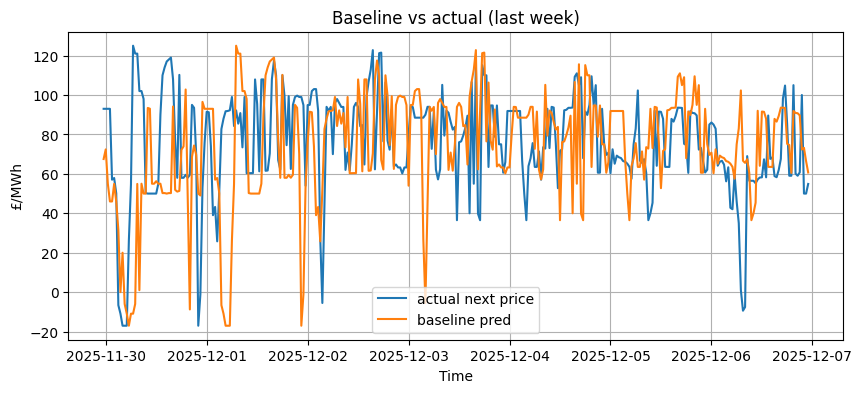

In [8]:
import matplotlib.pyplot as plt

#Quick Plot to check if i can trust it
sample = df.tail(48 * 7)  # last week
plt.figure(figsize=(10,4))
plt.plot(sample["ts"], sample["y"], label="actual next price")
plt.plot(sample["ts"], sample["pred_baseline"], label="baseline pred")
plt.title("Baseline vs actual (last week)")
plt.xlabel("Time")
plt.ylabel("£/MWh")
plt.grid(True)
plt.legend()
plt.show()